In [1]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from math import *
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.spatial import Delaunay
from scipy import ndimage
from scipy.interpolate import interp1d

In [2]:
# init the drawing and picture
dessin = cv2.imread('sourcil.png') 
image = cv2.imread("photo.png")
# resize
image = cv2.resize(image,dessin.shape[:2][::-1])

Get all the point of the drawing

In [11]:
# get the extremities so as to start at the correct place
# careful for the drawing : extremities must contain only one neighbor

def find_feature_ext(father,i,j,nb_features,union,res_dr,points_dr):
    grad_x = [-1,0,1]
    grad_y = [-1,0,1]
    n,m = union.shape
    for e1 in grad_x:
        for e2 in grad_y:
            x=i+e1
            y=j+e2
            if m*x+y!=father and dessin[x,y,0]!=255. and union[x,y]==m*x+y:    
                union[x,y]=father
                points_dr[father][x,y] = get_neighbors(x,y,dessin)
                find_feature_ext(father,x,y,nb_features,union,res_dr,points_dr)
# a parfaire parce que j'ai besoin que les extrémités aient un seul voisin (il faudrait regarder si elles ont deux voisins, si ils sont bien selon des e1 ET e2 différents)               
def get_extremities(img) :
    # the points of the drawing
    points_dr = {}    
    
    # union find for all the features
    union=np.zeros(dessin.shape[:2])
    (n,m)=union.shape
    for i in range(n):
        for j in range(m):
            union[i,j]=m*i+j
            
    res = {} # final result, after getting the right label
    res_dr = {} # temporary contains the points, that still need labeling before going into res
    nb_features=0
    for j in range(m):
        for i in range(n):
            if dessin[i,j,0]==255.:
                union[i,j]=0
            #premier pixel d'un feature
            elif union[i,j]==m*i+j:
                points_dr[m*i+j] = {}
                points_dr[m*i+j][i,j] = get_neighbors(i,j,dessin)
                
                find_feature_ext(m*i+j,i,j,nb_features,union,res_dr,points_dr)
                res_dr[str(nb_features)] = points_dr[m*i+j]
                nb_features+=1
    return res_dr

def get_neighbors(i,j,dessin) :
    S = -1
    neighbors = []
    for e1 in [-1,0,1] :
        for e2 in [-1,0,1] : 
            if dessin[i+e1,j+e2,0] != 255 :
                S +=1
                neighbors.append([i+e1,j+e2])
    
    return S

In [13]:
res  = get_extremities(dessin)
for k in res : 
    for key,values in res[k].items() :
            if values == 1 :
                print(key)
    print("next")

(137, 94)
(111, 299)
next
(136, 141)
(137, 177)
next
(150, 146)
(157, 151)
next
(230, 161)
(232, 162)
next
(151, 210)
(154, 213)
next
(138, 213)
(138, 247)
next


In [15]:
res = get_extremities(dessin)
ext = []
for k in res : 
    current_ext = []
    for key,values in res[k].items() :
        if values == 1 :
            current_ext.append(key)
    # how to choose? closest to (0,0)
    norm0 = np.linalg.norm(np.array(current_ext[0]))
    norm1 = np.linalg.norm(np.array(current_ext[1]))
    if norm0 > norm1 :
        ext.append(current_ext[1])
    else : 
        ext.append(current_ext[0])        

ext

[(137, 94), (136, 141), (150, 146), (230, 161), (151, 210), (138, 213)]

In [48]:
def find_feature(father,i,j,nb_features,union,res_draw,res_dr,points_dr):
    grad_x = [-1,0,1]
    grad_y = [-1,0,1]
    n,m = union.shape
    for e1 in grad_x:
        for e2 in grad_y:
            x=i+e1
            y=j+e2
            if m*x+y!=father and dessin[x,y,0]!=255. and union[x,y]==m*x+y:    
                union[x,y]=father
                points_dr[father].append([y,x])
                res_draw[str(nb_features)][x,y] = 255
                find_feature(father,x,y,nb_features,union,res_draw,res_dr,points_dr)
                

def compute_init_drawing() :
    # the points of the drawing
    points_dr = {}    
    
    # union find for all the features
    union=np.zeros(dessin.shape[:2])
    (n,m)=union.shape
    for i in range(n):
        for j in range(m):
            union[i,j]=m*i+j
            
    res = {} # final result, after getting the right label
    res_draw = {} # contains one image per feature, to help labeling
    res_dr = {} # temporary contains the points, that still need labeling before going into res
    nb_features=0
    for x,y in ext :
        points_dr[m*x+y] = [[y,x]]
        res_draw[str(nb_features)] = np.zeros(union.shape)
        res_draw[str(nb_features)][x,y] = 255
        find_feature(m*x+y,x,y,nb_features,union,res_draw,res_dr,points_dr)
        res_dr[str(nb_features)] = points_dr[m*x+y]
        nb_features+=1
                
    for k in res_draw :
        plt.imshow(res_draw[k])
        plt.show()
        feature = input("Which feature is it ?")
        res[feature] = res_dr[k]
        
    return res

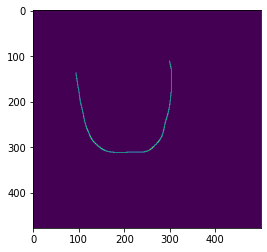

Which feature is it ?jaw


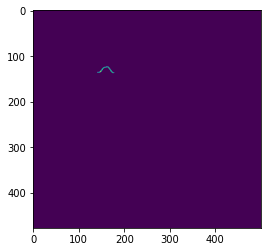

Which feature is it ?right_eyebrow


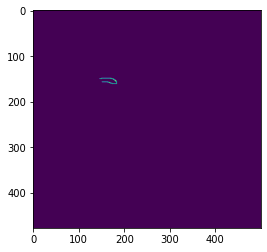

Which feature is it ?right_eye


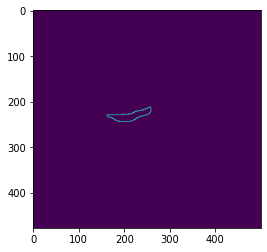

Which feature is it ?mouth


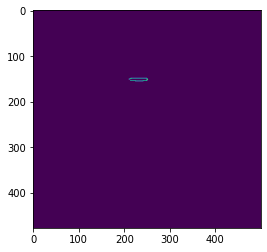

Which feature is it ?left_eye


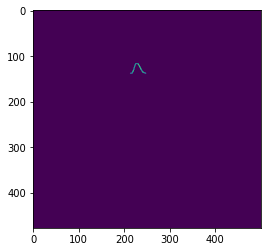

Which feature is it ?left_eyebrow


In [53]:
res_d = compute_init_drawing()

Code taken from a certain link thath we need to precise

In [54]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

def compute_init_pict(dessin,image) :
    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    # load the input image, resize it, and convert it to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    res = {}
    for rect in rects:
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        # loop over the face parts individually
        for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
            res[name] = {}
            res[name]["points"] = []
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            for (indice,(x, y)) in enumerate(shape[i:j]):
                res[name]["points"].append(shape[i:j][indice])

    mat_res = np.zeros(image.shape[:2])

    return res

In [51]:
res_im = compute_init_pict(dessin,image)

Points_tot contains, for each features identified on the drawing, the points on the drawing and image.

In [56]:
# add points according to cubic interpolation
# not so good for now
def add_points(points,part="jaw") :
    x = []
    y = []
    for a,b in points:
        x.append(a)
        y.append(b)
    if not (part in ["jaw",'left_eyebrow','right_eyebrow']) :
        x.append(points[0][0])
        y.append(points[0][1])
    t = [k for k in range(len(x))]
    new_points = []
    fx = interp1d(t, x, kind='cubic')
    fy = interp1d(t, y, kind='cubic')
    for i in t : 
        try : 
            # last point in the first point if we circle
            if i != len(t)-1 and not(part in ["jaw",'left_eyebrow','right_eyebrow']) :
                x_x = fx(i)
                y_y = fy(i)
                new_points.append([int(x_x),int(y_y)])
            elif (part in ["jaw",'left_eyebrow','right_eyebrow']) : 
                x_x = fx(i)
                y_y = fy(i)
                new_points.append([int(x_x),int(y_y)])
            x_x = fx(i+0.5)
            y_y = fy(i+0.5)
            new_points.append([int(x_x),int(y_y)])
        except :
            print("Okay mistake")
    return new_points

In [57]:
points_tot = {}
for k in res_d :
    points_tot[k] = {}
    points_tot[k]["drawing"] = res_d[k]
    if k == 'mouth' :
        points_tot[k]["image"] = add_points(res_im[k]["points"][:12],part=k)
    else :
        points_tot[k]["image"] = add_points(res_im[k]["points"],part=k)

Okay mistake
Okay mistake
Okay mistake
Okay mistake
Okay mistake
Okay mistake


In [58]:
def good_points(origine,goal) :
    # we have origine points (greater number) and want to obtain as much points as in goal
    n = len(goal)
    count = len(origine)
    obj = []
    interval = count//n
    for i in range(n) :
        obj.append(origine[i*interval])
    return obj

for k in points_tot : 
    points_tot[k]["drawing"] = good_points(points_tot[k]["drawing"],points_tot[k]["image"])

In [59]:
image_points = []
drawing_points = []
for k in points_tot :
    for i in points_tot[k]["image"] :
        image_points.append(i)
    for j in points_tot[k]["drawing"] :
        drawing_points.append(j)
'''image_points.append([0,0])
image_points.append([0,dessin.shape[1]-1])
image_points.append([dessin.shape[0]-1,0])
image_points.append([dessin.shape[0]-1,dessin.shape[1]-1])

drawing_points.append([0,0])
drawing_points.append([0,dessin.shape[1]-1])
drawing_points.append([dessin.shape[0]-1,0])
drawing_points.append([dessin.shape[0]-1,dessin.shape[1]-1])'''

'image_points.append([0,0])\nimage_points.append([0,dessin.shape[1]-1])\nimage_points.append([dessin.shape[0]-1,0])\nimage_points.append([dessin.shape[0]-1,dessin.shape[1]-1])\n\ndrawing_points.append([0,0])\ndrawing_points.append([0,dessin.shape[1]-1])\ndrawing_points.append([dessin.shape[0]-1,0])\ndrawing_points.append([dessin.shape[0]-1,dessin.shape[1]-1])'

In [60]:
test = image.copy()
for x,y in image_points :
    cv2.circle(test, (x, y), 1, (0, 0, 255), -1)
    cv2.imshow("test",test)
    cv2.waitKey(0)

We can know compute delaunay method to triangulate the image

In [61]:
points =np.array([list(coords) for coords in image_points])
drawing_points = np.array([list(coords) for coords in drawing_points])

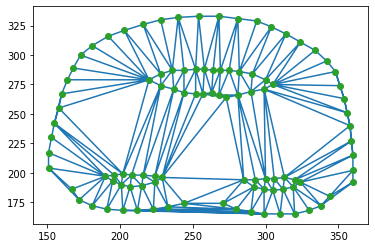

In [62]:
tri = Delaunay(points)
faces = tri.simplices # contains the point of each 
# care it is in the wrong sens
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

Now, we want to find, for each point in the drawing, the correct texture. Each point we identified on the drawing and image are linked by pair.

Here we have fonctions that, given a certain point, will determine its face and the coordinates in the face.

In [63]:
RIGHT = "RIGHT"
LEFT = "LEFT"

# whether the point in inside the polygone, here triangle
def inside_convex_polygon(point, vertices):
    previous_side = None
    n_vertices = len(vertices)
    for n in range(n_vertices):
        a, b = vertices[n], vertices[(n+1)%n_vertices]
        affine_segment = v_sub(b, a)
        affine_point = v_sub(point, a)
        current_side = get_side(affine_segment, affine_point)
        if current_side is None:
            return False #outside or over an edge
        elif previous_side is None: #first segment
            previous_side = current_side
        elif previous_side != current_side:
            return False
    return True

def get_side(a, b):
    x = cosine_sign(a, b)
    if x < 0:
        return LEFT
    elif x > 0: 
        return RIGHT
    else:
        return None

def v_sub(a, b):
    return (a[0]-b[0], a[1]-b[1])

def cosine_sign(a, b):
    return a[0]*b[1]-a[1]*b[0]

def get_face(point,F,V) :
    # given a point, return the face in which he is contained
    for ind,k in enumerate(F) :
        if inside_convex_polygon(point,[V[k[0]],V[k[1]],V[k[2]]]) :
            return ind 

# point = alpha * point[0] + beta * point[1] + gamma * point[2]
def get_coefs(point,vertices) :
    # one point and the three vertices
    M = np.ones((3,3))
    M[1,0] = vertices[0][0]
    M[1,1] = vertices[1][0]
    M[1,2] = vertices[2][0]
    
    M[2,0] = vertices[0][1]
    M[2,1] = vertices[1][1]
    M[2,2] = vertices[2][1]
    
    Y = np.zeros((3,1))
    Y[0,0] = 1
    Y[1,0] = point[0]
    Y[2,0] = point[1]
    
    return inv(M) @ Y

We now go through all inside pixels of the drawing, compute the corresponding face, its barycentric coeffs and find the corresponding point in the original image

In [64]:
def compute_height(img,j):
    min_idx=-1
    max_idx=-1
    for i in range(img.shape[0]):
        if img[i,j]!=0:
                if (min_idx<0):
                    min_idx=i
                else:
                    max_idx=i
    return min_idx,max_idx

#compute diameter of a 1 and 0 image, max horizontal distance between two ones
def compute_diameter(img):
    diameter=0
    start=0
    for i in range(img.shape[0]):
        min_idx=-1
        max_idx=-1
        for j in range(img.shape[1]):
            if img[i,j]!=0:
                if (min_idx<0):
                    min_idx=j
                else:
                    max_idx=j
        if (max_idx-min_idx)>diameter:
            start=min_idx
            diameter=max_idx-min_idx
    return diameter,start

# pas optimal pck parcoure toute l'image et pas l'enveloppe cvxe

In [65]:
#result matrix
deformed = np.zeros(dessin.shape)

for i in range(dessin.shape[1]):
    for j in range(dessin.shape[0]):
        for f in tri.simplices:
            l=list(drawing_points[v] for v in list(f))
            l2 = list(points[v] for v in list(f))
            if inside_convex_polygon([i,j],l):
                coefs=get_coefs([i,j],l)
                x = int(sum(coefs[i]*l2[i][0] for i in range(3) ))
                y = int(sum(coefs[i]*l2[i][1] for i in range(3) ))
                # a cause des arrondis, sometimes ca dépasse
                if x > dessin.shape[1]-1 :
                    x = dessin.shape[1] -1
                if y > dessin.shape[0]-1 :
                    y = dessin.shape[0] - 1
                deformed[j,i]=image[y,x]
                break

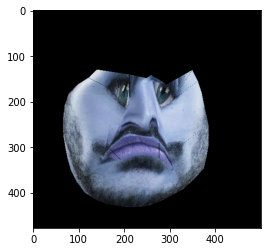

In [38]:
deformed = deformed.astype("uint8")
# deformed = ndimage.rotate(deformed, 90)
plt.imshow(deformed)
plt.show()

In [39]:
cv2.imshow("test",deformed)
cv2.waitKey(0)

-1

In [36]:
cv2.imwrite("res.png",deformed)

True